# (Frustratingly Easy) LLaVA OneVision Tutorial

We know that it's always beneficial to have a unified interface for different tasks. So we are trying to unify the interface for image, text, image-text interleaved, and video input. And in this tutorial, we aim to provide the most straightforward way to use our model. 

We use our 0.5B version as an example. This could be running on a GPU with 4GB memory. And with the following examples, you could see it's surprisingly have promising performance on understanding the image, interleaved image-text, and video. Tiny but mighty!

The same code could be used for 7B model as well.

## Inference Guidance

First please install our repo with code and environments: pip install git+https://github.com/LLaVA-VL/LLaVA-NeXT.git

Here is a quick inference code using [lmms-lab/qwen2-0.5b-si](https://huggingface.co/lmms-lab/llava-onevision-qwen2-0.5b-si) as an example. You will need to install `flash-attn` to use this code snippet. If you don't want to install it, you can set `attn_implementation=None` when load_pretrained_model

### Image Input
Tackling the single image input with LLaVA OneVision is pretty straightforward.

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch

import sys
import warnings

warnings.filterwarnings("ignore")
model_path = "lmms-lab/llava-onevision-qwen2-0.5b-si"
model_name = "llava_qwen"
device = "cuda"
device_map = "auto"
cache_dir = "/dpc/kunf0097/cache/models"
tokenizer, model, image_processor, max_length = load_pretrained_model(model_path, None, model_name, device_map=device_map, cache_dir=cache_dir)  # Add any other thing you want to pass in llava_model_args

model.eval()

In [ ]:


url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image_tensor = process_images([image], image_processor, model.config)
image_tensor = [_image.to(dtype=torch.float16, device=device) for _image in image_tensor]

conv_template = "qwen_1_5"  # Make sure you use correct chat template for different models
question = DEFAULT_IMAGE_TOKEN + "\nWhat is shown in this image?"
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size]


cont = model.generate(
    input_ids,
    images=image_tensor,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=4096,
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs)

You could use the following code to make it streaming in terminal, this would be pretty useful when creating a chatbot.

In [ ]:
from threading import Thread
from transformers import TextIteratorStreamer
import json

url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image_tensor = process_images([image], image_processor, model.config)
image_tensor = [_image.to(dtype=torch.float16, device=device) for _image in image_tensor]

conv_template = "qwen_1_5"
question = DEFAULT_IMAGE_TOKEN + "\nWhat is shown in this image?"
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size]

max_context_length = getattr(model.config, "max_position_embeddings", 2048)
num_image_tokens = question.count(DEFAULT_IMAGE_TOKEN) * model.get_vision_tower().num_patches

streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True, timeout=15)

max_new_tokens = min(4096, max_context_length - input_ids.shape[-1] - num_image_tokens)

if max_new_tokens < 1:
    print(
        json.dumps(
            {
                "text": question + "Exceeds max token length. Please start a new conversation, thanks.",
                "error_code": 0,
            }
        )
    )
else:
    gen_kwargs = {
        "do_sample": False,
        "temperature": 0,
        "max_new_tokens": max_new_tokens,
        "images": image_tensor,
        "image_sizes": image_sizes,
    }

    thread = Thread(
        target=model.generate,
        kwargs=dict(
            inputs=input_ids,
            streamer=streamer,
            **gen_kwargs,
        ),
    )
    thread.start()

    generated_text = ""
    for new_text in streamer:
        generated_text += new_text
        print(generated_text, flush=True)
        # print(json.dumps({"text": generated_text, "error_code": 0}), flush=True)

    print("Final output:", generated_text)

### Image-Text Interleaved Input

Now switching to our onevision model for more complex tasks. You should start to use `llava-onevision-qwen2-0.5b-ov` for image-text interleaved input and video input.

Processing image-text interleaved input is a bit more complicated. But following the code below should work.

In [ ]:
# Load model
model_path = "lmms-lab/llava-onevision-qwen2-0.5b-ov"
model_name = "llava_qwen"
device = "cuda"
device_map = "auto"
llava_model_args = {
        "multimodal": True,
    }
overwrite_config = {}
overwrite_config["image_aspect_ratio"] = "pad"
llava_model_args["overwrite_config"] = overwrite_config
tokenizer, model, image_processor, max_length = load_pretrained_model(model_path, None, model_name, device_map=device_map, **llava_model_args)

model.eval()

# Load two images
url1 = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
url2 = "https://raw.githubusercontent.com/haotian-liu/LLaVA/main/images/llava_logo.png"

image1 = Image.open(requests.get(url1, stream=True).raw)
image2 = Image.open(requests.get(url2, stream=True).raw)

images = [image1, image2]
image_tensors = process_images(images, image_processor, model.config)
image_tensors = [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]

# Prepare interleaved text-image input
conv_template = "qwen_1_5"
question = f"{DEFAULT_IMAGE_TOKEN} This is the first image. Can you describe what you see?\n\nNow, let's look at another image: {DEFAULT_IMAGE_TOKEN}\nWhat's the difference between these two images?"

conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size for image in images]

# Generate response
cont = model.generate(
    input_ids,
    images=image_tensors,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=4096,
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs[0])

### Video Input

Now let's try video input. It's the same as image input, but you need to pass in a list of video frames. And remember to set the `<image>` token only once in the prompt, e.g. "<image>\nWhat is shown in this video?", not "<image>\n<image>\n<image>\nWhat is shown in this video?". Since we trained on this format, it's important to keep the format consistent.

In [1]:
import torch
torch.cuda.device_count()

2

In [2]:
from llava.model.builder import load_pretrained_model, load_pretrained_model_simplified, connect_parent_lm_head
from llava.mm_utils import tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX
from llava.conversation import conv_templates

import numpy as np
import copy
import warnings
from decord import VideoReader, cpu

warnings.filterwarnings("ignore")

model_base = "lmms-lab/llava-onevision-qwen2-0.5b-ov"
model_name = "lora_llava_qwen"
device_map = {"":0}
model_path = "/dpc/kunf0097/out/checkpoints/v2-lora-llava-qwen-ov-s1-1112_020005" 
tokenizer, model, image_processor, max_length = load_pretrained_model_simplified(model_path, model_base, model_name, device_map=device_map, attn_implementation=None)

/dpc/kunf0097/.conda/envs/llavanext/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'device_map': {'': 0}, 'torch_dtype': torch.float16}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.


Loading LLaVA from base model...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading vision tower: google/siglip-so400m-patch14-384


Some weights of LlavaQwenForCausalLM were not initialized from the model checkpoint at lmms-lab/llava-onevision-qwen2-0.5b-ov and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model is loaded...
Model Class: LlavaQwenForCausalLM


In [4]:
model_path = "lmms-lab/llava-onevision-qwen2-0.5b-ov"
model_name = "llava_qwen"
model = connect_parent_lm_head(model, model_path, model_name, device_map)


{'device_map': {'': 0}, 'torch_dtype': torch.float16}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.


Loading vision tower: google/siglip-so400m-patch14-384
Model Class: LlavaQwenForCausalLM


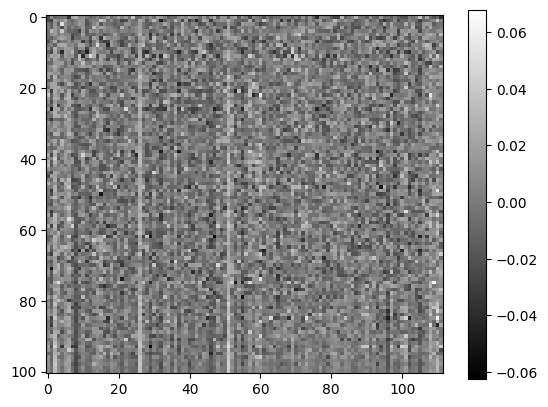

In [5]:
import matplotlib.pyplot as plt
a = model.lm_head.weight.data.cpu().numpy()
b = a[::a.shape[0]//100,::a.shape[1]//100]
plt.imshow(b, cmap="gray")
plt.colorbar()
plt.show()

In [6]:
# save model and tokenizer
save_path = "/dpc/kunf0097/.cache/huggingface/hub/v2-llava-qwen-ov-s1-1112_020005"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/dpc/kunf0097/.cache/huggingface/hub/v2-llava-qwen-ov-s1-1112_020005/tokenizer_config.json',
 '/dpc/kunf0097/.cache/huggingface/hub/v2-llava-qwen-ov-s1-1112_020005/special_tokens_map.json',
 '/dpc/kunf0097/.cache/huggingface/hub/v2-llava-qwen-ov-s1-1112_020005/vocab.json',
 '/dpc/kunf0097/.cache/huggingface/hub/v2-llava-qwen-ov-s1-1112_020005/merges.txt',
 '/dpc/kunf0097/.cache/huggingface/hub/v2-llava-qwen-ov-s1-1112_020005/added_tokens.json')

In [4]:
ex =  {
        "id": "cctv052x2004080607x01847",
        "video": "/dpc/kunf0097/data/high/video/cctv052x2004080607x01847.avi",
        "conversations": [
            {
                "from": "human",
                "value": "<image>\nYou are going to analyse a vehicular environment so you can assess the severity of any accident and/or congestion out of 5 along with your justification and predict the most probable cause. You will be provided with a video and scene description.\n\n#### Scene description:\nContext: weather: rain, time: 07:01, congestion: light, collision: no\nA template of the output looks like:\nAccident Severity: 0-5 (Accident severity score justification)\nCongestion Severity: 0-5 (Congestion Severity score justification)\nCause: State your prediction on the most probable cause\n"
            },
            {
                "from": "gpt",
                "value": "Accident Severity: 0 (No collision occurred.)\nCongestion Severity: 1 (Light congestion reported despite the rain.)\nCause: The light congestion and lack of accidents are likely due to drivers being more cautious in the rain."
            }
        ]
    }

In [4]:
# ex3
for_s3=True
ex = {
        "id": "cctv052x2004080607x01847",
        "video": "/dpc/kunf0097/data/high/video/cctv052x2004080607x01847.avi",
        "conversations": [
            {
                "from": "human",
                "value": "## Prompt: Deployable Service Recommender\n\nYou will act as a deployable service recommender based on the provided context.\n\nIn a vehicular environment, you will receive the following critical pieces of information:\n\n    - Accident Severity*:\n    - Collision Severity*: \n        *Severity: The score ranges from 0 to 5, derived from deep environmental analysis. Additionally, the justifcation reasoning will be provided for the score.\n    - Cause (most probable one):\n        This refers to the most probable cause responsible for the situation, whether it is an accident or congestion.\n\nBased on this context, you will recommend one of the following services:\n\n### Services\n    #### 1. Cooperative data sharing for incident reassessment\n        Use Case: High collision/accident severity.\n        Action: Open a service that utilizes in-vehicle OBUs (On-Board Units) to upload image/video feeds to a server for further analysis from multiple perspectives.\n    #### 2. Bandwidth Scaling Service to overcome resource scarcity\n        Use Case: High congestion severity.\n        Action: Overcome bandwidth limitations by increasing device bandwidth, enabling bandwidth-intensive services.\n    #### 3. (This is not a service, it's just a No-op for cases not at the top)\n        Use Case: No accident detected and congestion severity is low.\n        Action: No service is required. Simply note that everything is operating smoothly.\n\n### Response Style\n    This is a **zero-shot prompt**, so **DO NOT** ask for additional information.\n    Output must be concise and direct. Avoid irrelevant or lengthy sentences.\n\n### Example Response:\n    Here is an example, although you are allowed to customize it as you feel.\n    \"[some context you grasped] is observed which indicates [High/Low Accident and High/Low Congestion], [1/2/3. ][corresponding service] is suggested [with some justification, i.e what the service intends to solve].\"\n\n### Context\nAccident: severity 0 (No collision occurred.)\nCongestion: severity 1 (Light congestion reported despite the rain.)\nCause: The light congestion and lack of accidents are likely due to drivers being more cautious in the rain."
            },
            {
                "from": "gpt",
                "value": "No accident is detected, and congestion severity is low, indicating that everything is operating smoothly. 3. No service is required at this time."
            }
        ]
    }

In [ ]:

import numpy as np
import copy
from decord import VideoReader, cpu

# Function to extract frames from video
def load_video(video_path, max_frames_num):
    if type(video_path) == str:
        vr = VideoReader(video_path, ctx=cpu(0))
    else:
        vr = VideoReader(video_path[0], ctx=cpu(0))
    total_frame_num = len(vr)
    uniform_sampled_frames = np.linspace(0, total_frame_num - 1, max_frames_num, dtype=int)
    frame_idx = uniform_sampled_frames.tolist()
    spare_frames = vr.get_batch(frame_idx).asnumpy()
    return spare_frames  # (frames, height, width, channels)

if not for_s3:
    # Load and process video
    video_path = ex["video"]
    video_frames = load_video(video_path, 16)
    
    # Prepare the frames for the model
    frames = image_processor.preprocess(video_frames, return_tensors="pt")["pixel_values"]
    if device_map != "auto" or True:
        frames = frames.half().cuda()
    image_tensors = [frames]

# Prepare conversation input
conv_template = "qwen_1_5"
instruction = ex["conversations"][0]["value"]
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], instruction)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()
print(prompt_question)

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(model.device)
if not for_s3:
    image_sizes = [frame.size for frame in video_frames]

# Generate response
if for_s3:
    cont = model.generate(
        input_ids,
        do_sample=False,
        temperature=0,
        max_new_tokens=256,
    )
else:
    cont = model.generate(
        input_ids,
        images=image_tensors,
        image_sizes=image_sizes,
        do_sample=False,
        temperature=0,
        max_new_tokens=256,
        modalities=["video"],
    )
    
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print("-"*50)
print(text_outputs[0])
print("-"*50)
print(ex["conversations"][1]["value"])

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
name_or_path = "meta-llama/Llama-3.1-8B-Instruct"
device_map = {"":0}
model = AutoModelForCausalLM.from_pretrained(name_or_path, device_map=device_map, dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(name_or_path)

In [ ]:

import os
os.environ["TRITON_PTXAS_PATH"] = "/dpc/kunf0097/cu-11.8/bin/ptxas"
os.environ["TRITON_CUOBJDUMP_PATH"] = "/dpc/kunf0097/cu-11.8/bin/cuobjdump"
os.environ["TRITON_NVDISASM_PATH"] = "/dpc/kunf0097/cu-11.8/bin/nvdisasm"

In [ ]:
from lmdeploy import pipeline
from lmdeploy.vl import load_image

pipe = pipeline('llava-hf/llava-v1.6-mistral-7b-hf')

image = load_image('https://raw.githubusercontent.com/open-mmlab/mmdeploy/main/tests/data/tiger.jpeg')
response = pipe(('describe this image', image))
print(response)

In [ ]:
import torch
def compute_embeddings(paragraph, tokenizer, model):
    input_ids = tokenizer(paragraph, return_tensors='pt', truncation=True, padding=True).input_ids.to(model.device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        embeddings = hidden_states[-1]  # Get the last hidden state as embeddings

    return embeddings[:, -1, :]  # Get the last token's embedding

def compare_expected_and_generated(expected_paragraph, generated_paragraph, tokenizer, model, use_ref=True, reference=" "):
    expected_embeddings = compute_embeddings(expected_paragraph, tokenizer, model)
    generated_embeddings = compute_embeddings(generated_paragraph, tokenizer, model)

    cos_exp_gen = torch.nn.functional.cosine_similarity(expected_embeddings, generated_embeddings)
    if not use_ref:
        return cos_exp_gen.item()
    
    reference_embeddings = compute_embeddings(reference, tokenizer, model)
    cos_ref = torch.nn.functional.cosine_similarity(generated_embeddings, reference_embeddings).to(cos_exp_gen.device)
    
    cosine_similarity = torch.max((cos_exp_gen - cos_ref)/(1 - cos_ref), torch.tensor(0.0).to(cos_exp_gen.device))
    
    return cosine_similarity.item(z)

# Example usage
expected_paragraph = "Hey how are you doing?"
generated_paragraph = "Are you ok ."
cs = compare_expected_and_generated(expected_paragraph, generated_paragraph, tokenizer, model, use_ref=False)

print(f"Similarity Loss: {cs}")

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# # s1
# classes = ['Base', 'S1_1e', 'S1_10e']
# data = [".7723±.1972", ".90688±.067088", ".889768±.0743"]

# s2
# classes = ['Base', 'S1_1e', 'S1_10e', 'S2_1e', 'S2_10e']
# data = [".7382±.1638", ".8727±.0534", ".88139±.0743", ".9037±.0386", ".90348±.06081"]

# s3
classes = ["S3_1e", "S3_10e(base S2_1e)", "S3_10e"]
data = [".86385±.0662", ".85234±.08173", ".879±.0652"]

# Extracting accuracy and standard deviation from the string
accuracies = [float(d.split('±')[0]) for d in data]
std_devs = [float(d.split('±')[1]) for d in data]

# Plotting the graph
fig, ax = plt.subplots()
x = np.arange(len(classes))

ax.errorbar(
    x, accuracies, yerr=std_devs, fmt='o', color='red',
    ecolor='black', elinewidth=1, capsize=5, capthick=1
)
for acc in accuracies:
    ax.hlines(y=acc, xmin=0, xmax=len(classes)-1, colors='gray', linestyles='dashed', linewidth=1.5)

# Customizing the plot
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylim(0.76, 1)  # Extend y-axis slightly above 1 for better visibility
# ax.set_xlabel('Classes')
ax.set_ylabel('Qwen2 Embedded Cosine Similarity')
ax.set_title('Data: Input (A) (S3)')
# plt.grid()
plt.show()


#### visualize

In [1]:
from torchview import draw_graph
model_graph = draw_graph(model, input_data=input_ids)
model_graph.visual_graph

In [ ]:

from matplotlib import pyplot as plt
import json
import numpy as np
# global fig
# global ax
# fig, ax = plt.subplots()
def plot_from_file(file_path, color=None, label=None):
    with open(file_path) as f:
        data = json.load(f)
        if isinstance(data, dict):
            data = data['requests']

    x = [d["total_requests"] for d in data]
    y = [round(d["average_latency"], 4) for d in data]

    sorted_indices = sorted(range(len(x)), key=lambda i: x[i])
    x = [x[i] for i in sorted_indices]
    y = [y[i] for i in sorted_indices]
    y_std = np.random.uniform(0.49, 0.56, len(y)) * np.array(y)
    
    # choose a random color
    if color is None:
        color = np.random.rand(3,)
    
    # plt.errorbar(x, y, yerr=y_std, fmt='o', color=color, ecolor=color, elinewidth=1, capsize=2, capthick=1, markersize=2)
    plt.plot(x, y, color=color, linestyle='-', linewidth=1, marker='o', markersize=2, label=label)
# color similar to green is 
files = [
    ["2replicas_7b.json", "7B 2x GPU:32GBx2","red"],
    ["4replicas_4gpus_7b.json", "7B 4x GPU:32GBx4", "orange"],  
    ["2replicas_2gpus_05b.json", "0.5B 2x GPU:32GBx2", "green"],
    ["4replicas_2gpus_05b.json", "0.5B 4x GPU:32GBx4", "tab:blue"],
    # ["3replicas_0.5b.json", "orange"],
    # "3replicas.json",
    # ["6replicas_0.5b.json", "fdsa","purple"],  
    # "6replicas.json",
    # "9replicas_16_9gpu.json",  
    # "9replicas.json"
]
for file, label, color in files:
    plot_from_file(f"ray/out/{file}", label=label, color=color)

plt.title('Response Time vs. Number of Requests', fontsize=12, fontweight='bold')
plt.xlabel('Concurrent Requests', fontsize=10)
plt.ylabel('Response Time (s)', fontsize=10)

# x values multiples of 5 uptop 100 and 1
plt.xticks([1]+[i for i in range(5, 101, 5)])

# log scale y
plt.yscale('log')
plt.yticks([2, 5, 10, 20, 50, 100], [ 2, 5, 10, 20, 50, 100])

# plt.title('Response Time')
# plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10)

plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for s2 and s3
labels_s2 = ['0.5B 4bit', '0.5B 8bit', '0.5B 16bit', '7B 4bit', '7B 8bit', '7B 16bit']
labels_s3 = ['0.5B 4bit', '0.5B 8bit', '0.5B 16bit', '7B 4bit', '7B 8bit', '7B 16bit']
labels_s2s3 = ['0.5B 4bit', '0.5B 8bit', '0.5B 16bit', '7B 4bit', '7B 8bit', '7B 16bit']
s2_values = [2.626, 10.693, 3.842, 1.27, 6.05, 1.882]
s3_values = [7.05, 14.52, 11.7, 4.35, 8.95, 5.25]
s2s3_values = [s2+s3 for s2, s3 in zip(s2_values, s3_values)]

# Define x-axis positions
x_s2 = np.arange(len(s2_values))  # Positions for s2
x_s3 = x_s2 + len(s2_values) + 0.5  # Single gap between s2 and s3
x_s2s3 = x_s3 + len(s3_values) + 0.5  # Single gap between s2 and s3

fig, ax = plt.subplots(figsize=(12, 4))

# Plot s2 and s3 bars without gaps within each group
ax.bar(x_s2, s2_values, color='skyblue', label='s2', width=1.0)
ax.bar(x_s3, s3_values, color='salmon', label='s3', width=1.0)
ax.bar(x_s2s3, s2s3_values, color='orange', label='s2+s3', width=1.0)

# Set x-ticks and labels
ax.set_xticks(np.concatenate([x_s2, x_s3, x_s2s3]))  # Combining all x-ticks
ax.set_xticklabels(labels_s2 + labels_s3 + labels_s2s3)  # Adding both sets of labels

# Labels, title, and legend
ax.set_ylabel('Inference time (s)')
ax.legend()

# Y labels 1 to 14
# ax.set_yticks(np.arange(1, 15))

# rotate x-ticks
plt.xticks(rotation=45, ha='right')

plt.show()


#### wandb

In [1]:
import wandb
import pandas as pd

In [ ]:
https://wandb.ai/my-ku-org/huggingface/runs/wcutwl50

In [ ]:
run_a_b_id ="wcutwl50"
run_b_c_id = "jkea7ltb"
entity = "my-ku-org"
project = "huggingface"

api = wandb.Api()
run_a_b = api.run(f"{entity}/{project}/{run_a_b_id}")
run_b_c = api.run(f"{entity}/{project}/{run_b_c_id}")

# Convert the runs to pandas dataframes
history_a_b = run_a_b.history() 
history_b_c = run_b_c.history()
history_b_c['train/epoch'] = history_b_c['train/epoch'] + 1
combined_history = pd.concat([history_a_b, history_b_c], ignore_index=True)

In [ ]:
combined_history

In [ ]:
wandb.init(project=project, name="llava-qwen-ov-wz-1004_123605+s1-1015_215421", reinit=True)


In [24]:
# 4. Initialize a new WandB run for combined data

# 5. Log the combined data to WandB
for _, row in combined_history.iterrows():
    wandb.log(row.to_dict())

In [ ]:
wandb.finish()

#### bert

In [19]:
cands = '''28-year-old chef found dead in San Francisco mall
A 28-year-old chef who recently moved to San Francisco was found dead in the staircase of a local shopping center.
The victim's brother said he cannot imagine anyone who would want to harm him,"Finally, it went uphill again at him."
The corpse, found Wednesday morning in the Westfield Mall, was identified as the 28-year-old Frank Galicia from San Francisco, the Justice Department said in San Francisco.
The San Francisco Police Department said the death was classified as murder and the investigation is on the running.
The victim's brother, Louis Galicia, told the ABS broadcaster KGO in San Francisco that Frank, who formerly worked as a cook in Boston, had his dream job as a cook at the Sons & Daughters restaurant in San Francisco six months ago.
A spokesman for the Sons & Daughters said they were "shocked and destroyed on the ground" over his death.
"We are a small team that works like a close family and we are going to miss him painfully," said the spokesman.
Our thoughts and condolences are in this difficult time at Franks's family and friends.
Louis Galicia admitted that Frank initially lived in hostels, but that "things for him finally went uphill."'''

refs = '''28-Year-Old Chef Found Dead at San Francisco Mall
A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.
But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."
The body found at the Westfield Mall Wednesday morning was identified as 28-year-old San Francisco resident Frank Galicia, the San Francisco Medical Examiner's Office said.
The San Francisco Police Department said the death was ruled a homicide and an investigation is ongoing.
The victim's brother, Louis Galicia, told ABC station KGO in San Francisco that Frank, previously a line cook in Boston, had landed his dream job as line chef at San Francisco's Sons & Daughters restaurant six months ago.
A spokesperson for Sons & Daughters said they were "shocked and devastated" by his death.
"We are a small team that operates like a close knit family and he will be dearly missed," the spokesperson said.
Our thoughts and condolences are with Frank's family and friends at this difficult time.
Louis Galicia said Frank initially stayed in hostels, but recently, "Things were finally going well for him."'''

cands, refs = cands.split('\n'), refs.split('\n')

In [23]:
import json
with open("out/Qwen2-7B-Instruct/s1_test_llava-qwen-ov-s1-1015_215421.json") as f:
    data = json.load(f)
generated = [d["generated"] for d in data]
expected = [d["expected"] for d in data]

In [20]:
from bert_score import score

In [ ]:
model_type = "microsoft/deberta-xlarge-mnli"
P, R, F1 = score(cands, refs, lang="en", model_type=model_type, verbose=False)

In [ ]:
P.mean(), R.mean(), F1.mean()
# P.std(), R.std(), F1.std()

In [ ]:
P.mean().item()

In [ ]:
import matplotlib.pyplot as plt
plt.hist(F1, bins=90)
plt.show()

In [ ]:
from bert_score import plot_example

cand = cands[0]
ref = refs[0]
plot_example(expected[0], generated[0], lang="en",  model_type=model_type)

In [58]:
import os
from bert_score import score

def process_file(file_path):
    with open(file_path) as f:
        data = json.load(f)
    
    generated = [d["generated"] for d in data]
    expected = [d["expected"] for d in data]
    
    model_type = "microsoft/deberta-xlarge-mnli"
    P, R, F1 = score(generated, expected, lang="en", model_type=model_type, verbose=True)
    print(P.mean().item(), R.mean().item(), F1.mean().item())
    # print(P.std().item(), R.std().item(), F1.std().item())
    print("-"*50)
    # pass
    
    
def find_and_process_files(directory, identifier_list):
    all_files = os.listdir(directory)

    for identifier in identifier_list:
        matches = [f for f in all_files if identifier in f]
        
        if matches:
            for i, file in enumerate(matches):
                file_path = os.path.join(directory, file)
                print(f"{i}. {file_path}")
                process_file(file_path)
        else:
            print(f"No matches found for identifier '{identifier}'.")

directory_path = "out/Qwen2-7B-Instruct"
identifier_list = [
    "1028_125343", #s1
    "1028_182909", #s2
    "1027_230740", #direct
    "1030_002733", #s3
    "1027_174437", #s1
    "1028_235232", #s2
    "1030_122125"  #s3
    ]
find_and_process_files(directory_path, identifier_list)


#### hf evaluate

In [2]:
import evaluate


In [15]:
em1 = evaluate.load('bertscore', model_dtype='metric')

In [5]:
em = evaluate.load('perplexity', model_dtype='metric')

In [ ]:
s = em1.compute(references=refs, predictions=cands, model_type="microsoft/deberta-xlarge-mnli")
def avg(l):
    return sum(l) / len(l)
print(avg(s['precision']), avg(s['recall']), avg(s['f1']))


In [ ]:
s = em.compute(references=['hello how'], predictions=['hello how'], model_id="facebook/opt-350m")
s

In [ ]:
evaluate.list_evaluation_modules(module_type="metric", with_details=True, include_community=True)

In [ ]:
evaluate